In [1]:
%cd ..

/hdd/aouadt/these/projets/3d_segm


In [2]:
from importlib import reload

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import torch
import k3d

import general.nn.viz.canva as cva
import general.nn.viz.element as viz_element
import general.nn.viz.plot_symbols as ps
import general.nn.viz.plot_letters as plet
import general.nn.viz.element_symbols as es
import general.nn.viz.element_image as ei
import general.nn.viz.element_arrow as ea
import general.nn.viz.element_circle as ec
import general.nn.viz.element_letters as el
import general.nn.viz.plot_histogram as ph
import general.nn.viz as all_viz
import deep_morpho.viz.element_arrow_no as eltarno
import deep_morpho.morp_operations as mo
import deep_morpho.viz.morp_operations_viz as mov
import deep_morpho.viz.elt_generator_morpop as elgenmo
# import deep_morpho.viz.morp_operations_viz2 as mov2

import deep_morpho.models.bimonn as bimonn
import deep_morpho.viz.element_lui as elui
# import deep_morpho.viz.element_lui2 as elui2
import deep_morpho.viz.element_bise as ebise
import deep_morpho.viz.element_generator as egen
import deep_morpho.viz.skeleton_morp_viz as skmov
import deep_morpho.viz.elt_generator_init as egen_init
import deep_morpho.viz.elt_generator_bimonn as egen_bimonn
import deep_morpho.viz.bimonn_viz as bviz
# import deep_morpho.viz.bimonn_viz2 as bviz2

def reload_modules():
    for modl in [
        cva, viz_element, ps, plet, es, ei, ea, ec, el, ph, all_viz, eltarno, mo, mov, elgenmo,
        bimonn, elui, ebise, bviz, egen, skmov, egen_init, egen_bimonn
    ]:
        reload(modl)

# Some level sets

In [2]:
N = 200

XX, YY = np.meshgrid(np.arange(N), np.arange(N))

In [3]:
def plot_lvset_ax(ax, im, eps=2e-3):
    mask = np.zeros_like(im)
    im_norm = im / im.max()
    mask[(-eps < im_norm) & (im_norm < eps)] = 1
    mask = np.ma.masked_where(mask == 0, mask)
    ax.imshow(im, cmap='gray')
    ax.imshow(mask, cmap='jet')

In [4]:
def get_circle_fn(center, radius):
    def fn(*x):
        return np.sqrt((x[0] - center[0])**2 + (x[1] - center[1])**2) - radius
    return fn

def Rtheta(theta):
    return np.array([
        [np.cos(theta), np.sin(theta)],
        [-np.sin(theta), np.cos(theta)]
    ])

def get_square_fn(center, radius, angle):
    def fn(*x):
        W, L = x[0].shape
        Xs = x[0].reshape(W*L)
        Ys = x[1].reshape(W*L)
        coords = np.vstack((Xs, Ys))
        return (
            np.abs(Rtheta(theta) @ (coords - center[..., np.newaxis])).sum(0) - radius
        ).reshape(W, L)
    return fn


In [71]:
def get_ellipse_fn(center, matrix, radius):
    def fn(*x):
        W, L = x[0].shape
        Z = np.zeros_like(x[0])
        for i in range(W):
            for j in range(L):
                coord = np.array([x[0][i, j], x[1][i, j]]) - center
                coord = coord[:, np.newaxis]
                Z[i, j] = np.sqrt( coord.T @ matrix @ coord) - radius
        return Z
    return fn

In [119]:
A = np.array([
    [4, 2],
    [2, 2]
]) * 5
center = np.array([75, 60])
radius = 100

fn_ellipse = get_ellipse_fn(center, A, radius)
lvset = fn_ellipse(XX, YY)

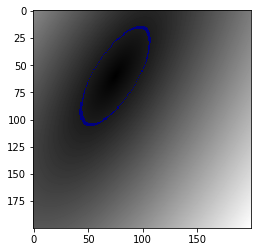

In [120]:
fig, ax = plt.subplots()
plot_lvset_ax(ax, lvset, 5e-3)

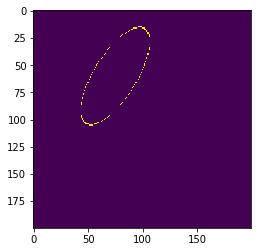

In [123]:
eps = 1e-1
mask = np.zeros_like(lvset)
mask[(-eps < lvset) & (lvset < eps)] = 1
plt.imshow(mask, interpolation='nearest')

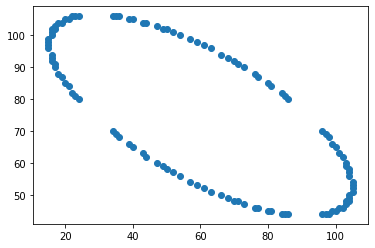

In [124]:
Xs, Ys = np.where(mask)
plt.scatter(Xs, Ys)

In [115]:
c = np.array([100, 100])
r = 50
theta = np.pi / 3

sq_fn = get_square_fn(c, r, theta)

lvset = sq_fn(XX, YY)

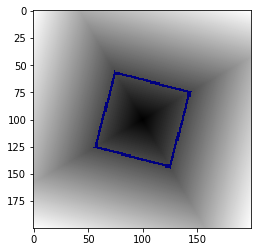

In [6]:
fig, ax = plt.subplots()
plot_lvset_ax(ax, lvset, 2e-2)

In [180]:
c = np.array([150, 100])
r = 20

cir_fn = get_circle_fn(c, r)

lvset = cir_fn(XX, YY)

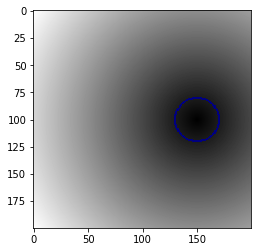

In [182]:
fig, ax = plt.subplots()
plot_lvset_ax(ax, lvset, 1e-2)

# Plot Symbols

<AxesSubplot:>

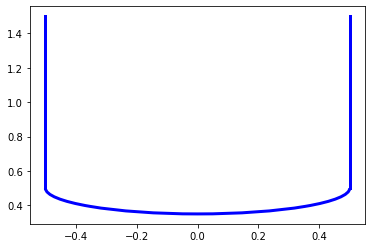

In [8]:
reload_modules()

fig, ax = plt.subplots(1,1)

ps.plot_union_on_ax(ax, [0, 1], color='blue', linewidth=3)

<AxesSubplot:>

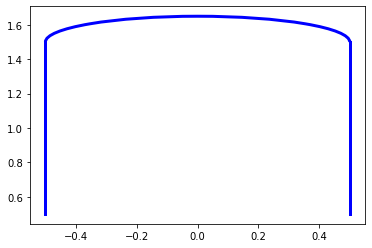

In [42]:
reload_modules()

fig, ax = plt.subplots(1,1)

ps.plot_intersection_on_ax(ax, [0, 1], color='blue', linewidth=3)

<AxesSubplot:>

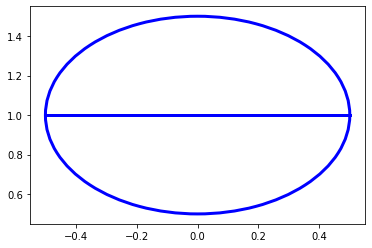

In [9]:
reload_modules()

fig, ax = plt.subplots(1,1)

ps.plot_erosion_on_ax(ax, [0, 1], color='blue', linewidth=3)

<AxesSubplot:>

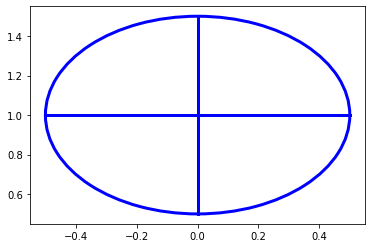

In [47]:
reload_modules()

fig, ax = plt.subplots(1,1)

ps.plot_dilation_on_ax(ax, [0, 1], color='blue', linewidth=3)

<AxesSubplot:>

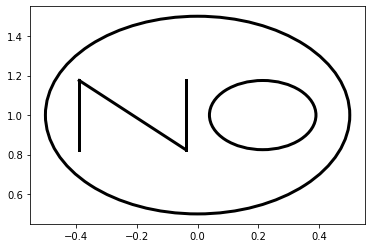

In [33]:
reload_modules()

fig, ax = plt.subplots(1,1)

plet.plot_NO_on_ax(ax, width=1, center=[0, 1], linewidth=3)

<AxesSubplot:>

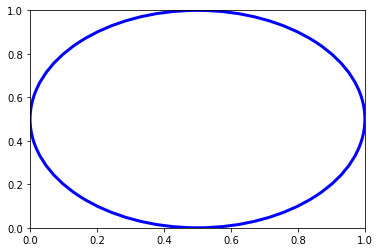

In [23]:
reload_modules()

fig, ax = plt.subplots(1,1)

plet.plot_O_on_ax(ax, height=1, center=[0.5, .5], color='blue', linewidth=3)

# Plot Histogram

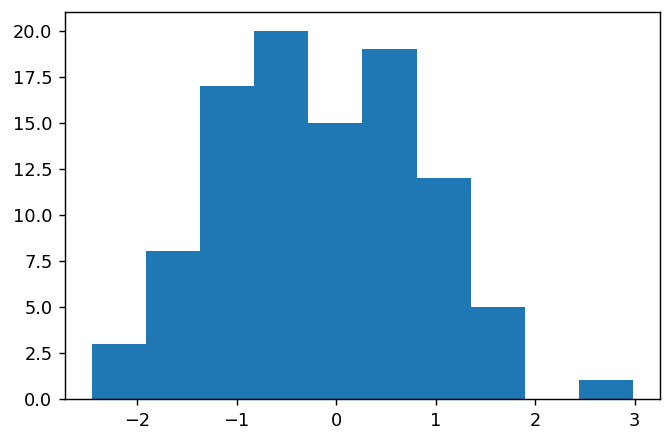

In [24]:
x = np.random.randn(100)

fig, ax = plt.subplots(dpi=128)
ax.hist(x);

In [22]:
x = 2 * (torch.rand((32, 1, 50, 50)).view(-1).numpy() + 20)
ar = ph.get_hist_as_array(x, dpi=50, density=True)
print(ar.shape)
# plt.imshow(ar)



(200, 300, 4)


# Plot Parallel Morp Ops

In [3]:
# morp_operation = mo.ParallelMorpOperations(
#     operations=[
#         [
#             [("erosion", ("vstick", 7), False), "intersection"],
#             [("dilation", ("dcross", 7), False), "union"]
#         ],
#         [
#             [("dilation", ("scross", 7), False), ("erosion", ("square", 7), False), ("intersection", [0])],
#             [("dilation", ("scross", 7), False), ("erosion", ("square", 7), False), "intersection"],
#         ],
#     ]
# )
# morp_operation = mo.ParallelMorpOperations.opening(("disk", 3))
morp_operation = mo.ParallelMorpOperations.black_tophat(('disk', 3))

Viz 1


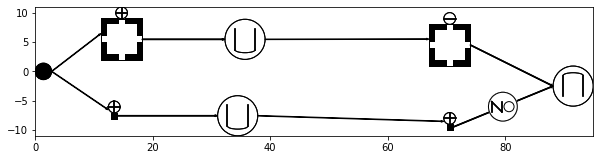

In [38]:
reload_modules()
visu = mov.MorpOperationsVizualiser(morp_operation);
# layer_group = visu.get_layer_group(0)
visu.draw(figsize=(10, 10), axis="on")
print("Viz 1")


Viz 2


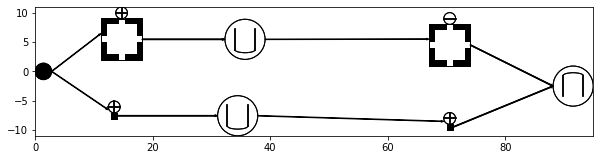

In [23]:
reload_modules()
visu = mov2.MorpOperationsVizualiser(morp_operation);
# layer_group = visu.get_layer_group(0)
visu.draw(figsize=(10, 10), axis="on")
print("Viz 2")


# Plot BiMoNN

In [3]:
reload_modules()
# net = bimonn.BiMoNN(
#     kernel_size=[5, 5, 5, 5],
#     channels=[1, 2, 3, 2, 1],
#     atomic_element="bisel",
#     threshold_mode="tanh",
#     constant_activation_P=False,
#     constant_weight_P=True,
#     init_weight_mode="conv",
# )
net = bimonn.BiMoNNClassifier(
    kernel_size=[5, 5],
    input_size=(28, 28),
    n_classes=10,
    channels=[1, 2, 1],
    atomic_element="bisel",
    threshold_mode="tanh",
    constant_activation_P=False,
    constant_weight_P=True,
    init_weight_mode="conv",
)
net.layers[1].bise_0.activation_threshold_layer.P_.requires_grad= False
net.layers[1].bise_0.activation_threshold_layer.P_.data = torch.tensor([-10])

/hdd/aouadt/these/projets/3d_segm/deep_morpho/models/bise.py:130: UserWarning: init weight mode conv not recognized. Classical conv init used.
  warnings.warn(f"init weight mode {self.init_weight_mode} not recognized. Classical conv init used.")


Viz 1


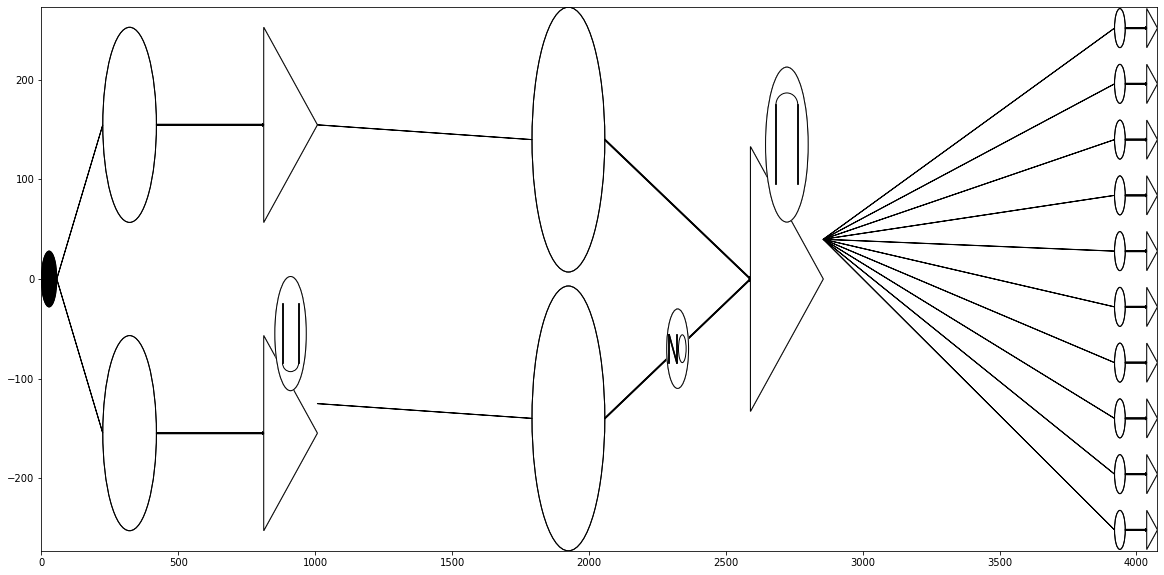

In [4]:
reload_modules()
viz = bviz.BimonnVizualiser(net, mode='learned')
viz.draw(axis="on", figsize=(20, 10))
print('Viz 1')

Viz 2


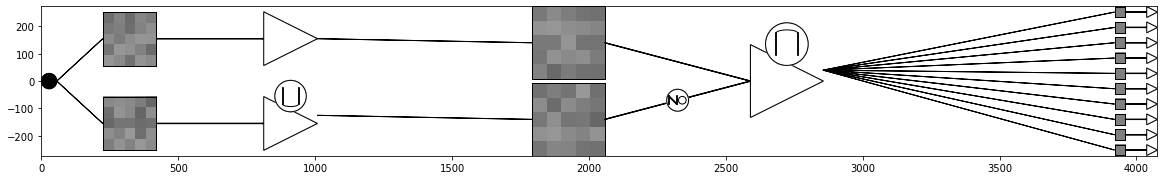

In [5]:
reload_modules()
viz = bviz.BimonnVizualiser(net, mode="weights")
viz.draw(axis="on", figsize=(20, 10))
print("Viz 2")

Viz 2


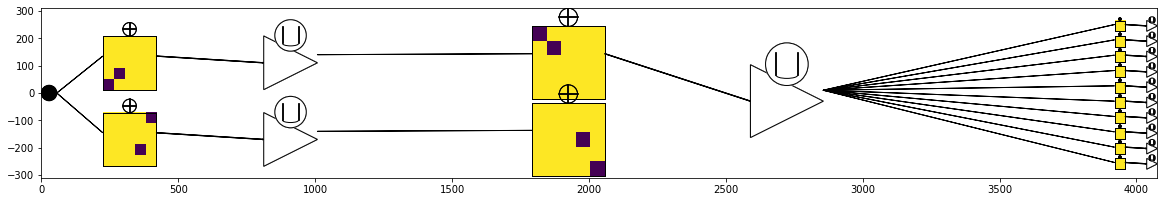

In [6]:
reload_modules()
viz = bviz.BimonnVizualiser(net, mode="closest")
viz.draw(axis="on", figsize=(20, 10))
print("Viz 2")

[6. 3.]
[56.       19.115625]
[96. 26.]
[136.   24.5]
[176.   17.5]


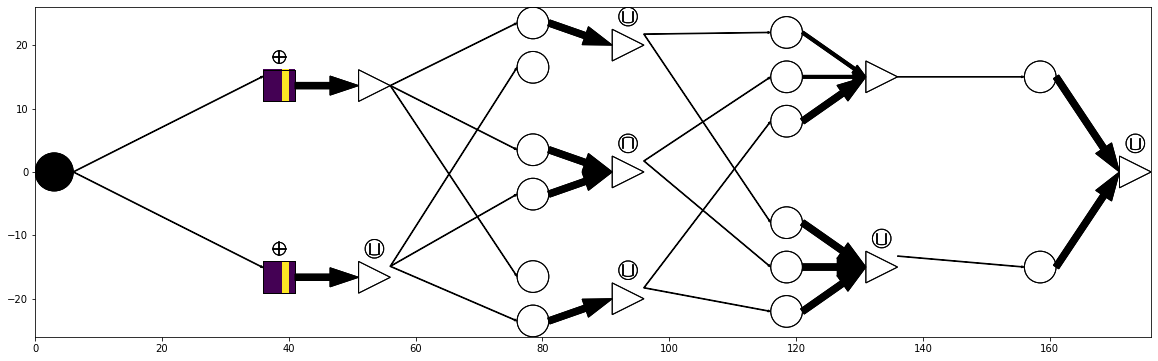

In [44]:
reload_modules()
viz = bviz.BimonnVizualiser(net, mode='selem')
viz.draw(axis="on", figsize=(20, 10))

In [81]:
viz.box_height

42

In [45]:
viz.box_height

60

# Faisable binary sets

In [49]:
# S1 = (1, 0)
xs = np.arange(20)
ys = np.arange(20)
zs = np.arange(20)

S1 = []
for x in xs:
    for y in range(x + 1, 20):
        for z in range(x, y):
            S1.append(np.array([x, y, z]) / 20)
S1 = np.array(S1)

S2 = []
for y in xs:
    for x in range(y + 1, 20):
        for z in range(y, x):
            S2.append(np.array([x, y, z]) / 20)
S2 = np.array(S2)

S3 = []
for x in xs:
    for y in ys:
        for z in range(0, min(x, y)):
            S3.append(np.array([x, y, z]) / 20)
S3 = np.array(S3)

In [53]:
plot_S1 = k3d.points(positions=S1[::10], point_size=0.01, color=0xff0000)
plot_S2 = k3d.points(positions=S2[::10], point_size=0.01, color=0x4dff00)
plot_S3 = k3d.points(positions=S3[::10], point_size=0.01,)

plot = k3d.plot()
plot += plot_S1 + plot_S2 + plot_S3
plot

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, background_color=16777215, camera_animation=[], camer…

In [58]:
plot_S1 = k3d.points(positions=S1[::10], point_size=0.01, color=0xff0000)
plot_S2 = k3d.points(positions=S2[::10], point_size=0.01, color=0x4dff00)
plot_S3 = k3d.points(positions=S3[::10], point_size=0.01,)


plot = k3d.plot()
vertices_w2 = [[0, 0, 0], [0, 1, 1], [1, 0, 0], [1, 1, 1]]
indices_w2 = [[0, 1, 2], [1, 2, 3]]
mesh_w2 = k3d.mesh(vertices_w2, indices_w2, opacity=.9, color=0xff0000)

vertices_w1 = [[0, 0, 0], [1, 0, 1], [0, 1, 0], [1, 1, 1]]
indices_w1 = [[0, 1, 2], [1, 2, 3]]
mesh_w1 = k3d.mesh(vertices_w1, indices_w1, opacity=.9, color=0x4dff00)


plot += plot_S1 + plot_S2 + plot_S3
plot += mesh_w2
plot += mesh_w1
plot

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, background_color=16777215, camera_animation=[], camer…